# CNN Quantisation Tutorial

This tutorial introduces basic ideas in the field of CNN quantisation.
You will first learn how to wrap up fixed-point data objects and their arithmetic in Python.
Then, after training a toy CNN model for MNIST, you can quantise it to a specific fixed-point format and inference it.

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from __future__ import absolute_import

import math
import time
from collections import OrderedDict
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from mnist_deep import deepnn

## Fixed-Point Arithmetic

In this section, we will implement fixed-point number classes in Python, including their representation and arithmetic.
These classes will be further used in later sections.

A [**fixed-point** number](https://en.wikipedia.org/wiki/Fixed-point_arithmetic) has fixed number of digits before and after a **radix point**.
Normally we represent a fixed-point number in Q format, which specifies the number of integer bits (m) and fractional bits (n) by Qm.n .
The total number of bits is m + n + 1 and the signed bit is implicitly allocated.
The representation of unsigned format is prefixed with **U**, e.g. UQm.n .

You only need to implement signed Q format in this tutorial, and we restrict the total number of bits to be **8**.
See `QInt8` for the fixed-point class definition and try to implement its member functions.

You can check this [page](https://en.wikipedia.org/wiki/Q_(number_format)) for some hints.

In [4]:
"""
Implementation of the 8-bit Q format.
"""

class QInt8(object):
    
    def __init__(self, n, val):
        """
        instance initialisation function
        
        :param n: number of fractional bits
        :param val: initialise value, can be float or QInt8
        :return: initialised object
        """
        assert isinstance(n, int), "n should be an integer"
        assert n >= 0 and n <= 7,  "n should in range [0, 7]"
        assert isinstance(val, float) or isinstance(val, np.int8), "val should be a float or int8"
        
        """
        TODO: try to implement a initialisation function for QInt8
        Note that it should handle both types of initial values (float or np.int8)
        """
        self.n = n
        self.m = 7 - self.n
        self.max_val = (1 << self.m) - 1. / (1 << self.n)
        self.min_val = - (1 << self.m - 1)
        
        # if initialise value is a float, we convert it to fixed-point format
        if isinstance(val, float):
            if val > self.max_val:
                print('WARNING: Initial value overflow %.6f > %.6f'  % (val, self.max_val))
                self.val = self.max_val
            elif val < self.min_val:
                print('WARNING: Initial value underflow %.6f < %.6f' % (val, self.min_val))
                self.val = self.min_val
            else:
                self.val = val
            # round to the nearest integer value and cast to int8 (char)
            self.val = np.int8(round(val * (1 << self.n)))
        # else we just assign
        elif isinstance(val, np.int8):
            self.val = val
        else:
            raise RuntimeError('Should never reach this point!')

    def __repr__(self):
        return 'QInt8(%d, %d) %s %f' % (7 - self.n, self.n, hex(self.val), float(self))
    
    @staticmethod
    def sat8(val):
        """
        TODO: Try to implement this saturation function.
        You need to return the upperbound when overflow and lowerbound when underflow.
        """
        if val > 0x7F:  return 0x7F
        if val < -0x80: return -0x80
        return val
   
    """
    TODO: Implement basic arithmetics between two QInt8 objects of the same precision
    i.e. self.n == q.n

    Could you also use the sat8 function you defined above?
    """
    def __add__(self, q):
        assert isinstance(q, QInt8), "The other operand should be of QInt8 type"
        assert q.n == self.n, "Number of fractional bits should match"
        
        tmp = np.int16(self.val) + np.int16(q.val)
        return QInt8(self.n, np.int8(self.sat8(tmp)))
    
    def __sub__(self, q):
        assert isinstance(q, QInt8), "The other operand should be of QInt8 type"
        assert q.n == self.n, "Number of fractional bits should match"
        
        tmp = np.int16(self.val) - np.int16(q.val)
        return QInt8(self.n, np.int8(self.sat8(tmp)))
    
    def __mul__(self, q):
        assert isinstance(q, QInt8), "The other operand should be of QInt8 type"
        assert q.n == self.n, "Number of fractional bits should match"
        
        tmp = np.int16(self.val) * np.int16(q.val)
        tmp = tmp + (1 << (self.n - 1))
        tmp = tmp >> self.n
        # print(hex(q.val))
        return QInt8(self.n, np.int8(self.sat8(tmp)))
    
    def __truediv__(self, q):
        assert isinstance(q, QInt8), "The other operand should be of QInt8 type"
        assert q.n == self.n, "Number of fractional bits should match"
        
        tmp = np.int16(self.val) << self.n
        if (tmp >= 0 and q.val >= 0) or (tmp < 0 and q.val < 0):
            tmp = tmp + q.val / 2
        else:
            tmp = tmp - q.val / 2
        return QInt8(self.n, np.int8(tmp / q.val))
    
    def __float__(self):
        return float(self.val) / (1 << self.n)

In [5]:
# Maybe you can try with some other examples to see whether you implemented correctly.
q1 = QInt8(4, 1.26)
q2 = QInt8(4, - 2.1)

print(q1 + q2)
print(q1 - q2)
print(q1 * q2)
print(q1 / q2)
print(float(q1))

QInt8(3, 4) -0xe -0.875000
QInt8(3, 4) 0x36 3.375000
QInt8(3, 4) -0x2a -2.625000
QInt8(3, 4) -0x9 -0.562500
1.25


### Challenges (No Solution)

1. Mixed-precision: Can you support arithmetic between operands in different precisions? (hint: use shift)
2. Can you define and calculate a metric that evaluates the "goodness" of a precision on a given tensor?
3. Can you provide a process that can search for the best precision, regarding the goodness metric defined above, of a given tensor?

## MNIST in TensorFlow

In this section, we build a CNN for MNIST classification in TensorFlow.
The aim is to extract coefficients from the TensorFlow pre-trained model and convert them to quantised format.

The code block below trains a CNN for MNIST classification. It has two convolution layers, two max-pooling layers, two fully-connected layers, and a dropout layer.
You just need to run the code block below.
Later we will try to extract coefficients from the model you trained.

In [6]:
"""
TODO: just run this code block
"""
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])

mnist = input_data.read_data_sets('mnist', one_hot=True)

Y_conv, keep_prob = deepnn(X)

with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=Y_conv)
    cross_entropy = tf.reduce_mean(cross_entropy)
with tf.name_scope('adam_optimizer'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(Y_conv, 1), tf.argmax(Y, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                X: batch[0], Y: batch[1], keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))
            
        train_step.run(feed_dict={X: batch[0], Y: batch[1], keep_prob: 0.5})

    print('test accuracy %g' % accuracy.eval(feed_dict={
        X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1.0}))
    
    graph = tf.get_default_graph()
    graph_def = graph.as_graph_def()
    graph_def = tf.graph_util.convert_variables_to_constants(sess,
                                                             graph_def,
                                                             output_node_names=[Y_conv.name.split(':')[0]])

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
step 0, training accuracy 0.18
step 100, training accuracy 0.76
step 200, training accuracy 0.94
step 300, training accuracy 0.9
step 400, training accuracy 0.94
step 500, training accuracy 0.92
step 600, training accuracy 0.92
step 700, training accuracy 0.92
step 800, training accuracy 0.98
step 900, training accuracy 0.98
test accuracy 0.9645
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.


### Create Data Map

From the trained CNN model we can build a data map.
The code block below creates a `data_map` based on the model (i.e. `graph_def`) you have just trained.

You can further quantise the `data_map` in later sections.

In [7]:
def get_const_data(node_name, node_map):
    tensor = node_map[node_name].attr['value'].tensor
    return np.frombuffer(tensor.tensor_content,
                         dtype=np.float32)

data_map = OrderedDict()

node_map = {}
for node in graph_def.node:
    node_map[node.name] = node
    
data_map['weights'] = OrderedDict()
data_map['weights']['conv1'] = get_const_data('conv1/Variable', node_map).reshape((5, 5, 1, 32))
data_map['weights']['conv2'] = get_const_data('conv2/Variable', node_map).reshape((5, 5, 32, 64))
data_map['weights']['fc1'] = get_const_data('fc1/Variable', node_map).reshape((1024, 7 * 7 * 64))
data_map['weights']['fc2'] = get_const_data('fc2/Variable', node_map).reshape((10, 1024))

data_map['bias'] = OrderedDict()
data_map['bias']['conv1'] = get_const_data('conv1/Variable_1', node_map)
data_map['bias']['conv2'] = get_const_data('conv2/Variable_1', node_map)
data_map['bias']['fc1'] = get_const_data('fc1/Variable_1', node_map)
data_map['bias']['fc2'] = get_const_data('fc2/Variable_1', node_map)

Can you implement the following functions that can convert a vector from `float` to `QInt8`?

In [8]:
def convert_to_qint8(X, n):
    """
    TODO: assign the converted vector from X to list_of_qint8.
    n is the number of fractional bits.
    """
    list_of_qint8 = [QInt8(n, float(x)) for x in X]
    return np.array(list_of_qint8)

In [9]:
def create_qint8_data_map(data_map, n_s):
    qint8_data_map = OrderedDict()
    for group in data_map:
        qint8_data_map[group] = OrderedDict()
        for idx, layer in enumerate(data_map[group].keys()):
            shape = data_map[group][layer].shape
            qint8_data_map[group][layer] = convert_to_qint8(
                data_map[group][layer].reshape(-1), n_s[idx]).reshape(shape)
    return qint8_data_map

Now you have the quantised `data_map` (`qint8_data_map`) of the trained MNIST CNN model.

In [12]:
%%time
# suppose we use 3 as the number of fractional bits for all layers
qint8_data_map = create_qint8_data_map(data_map, [3, 3, 3, 3])

CPU times: user 10.4 s, sys: 164 ms, total: 10.5 s
Wall time: 10.5 s


### Challenges (No Solution)

1. Can you try to quantise the `data_map` with different precisions for different layers?
2. Can you evaluate the goodness of your current precision setting?
3. Can you search for the **best** precision setting for the current trained coefficients?

## Quantised CNN Layers

This section implements typical CNN layers with quantised data types.
Coefficients are converted from pre-trained values in floating-point to fixed-point.
We will show intermediate results to see how the quantised layers work.

You don't need to implement these layers. We already provide the naive solutions. You can just re-run them and experience with 
other test images.

### Quantised Input Images

`images` is a numpy array contains quantised MNIST test images.

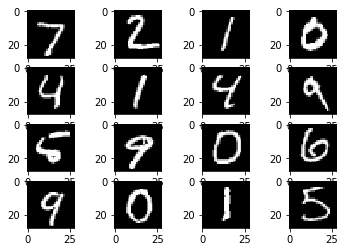

In [9]:
NUM_TEST_IMAGES = 100

# convert input images to quantised images
images = np.array([
    convert_to_qint8(X, 3).reshape(1, 28, 28)
    for X in mnist.test.images[:NUM_TEST_IMAGES]])

# show some samples
f, axarr = plt.subplots(4, 4)
for x, y in product(range(4), range(4)):
    img = images[x * 4 + y].astype(float).reshape(28, 28)
    axarr[x, y].imshow(img, cmap='gray')

### Quantised CNN Layers implementation

Since we already have the definition of `QInt8`, we can straightforwardly implement each type of CNN layer.

In [10]:
def conv2d(X, W, b):
    """
    naive implementation
    """
    num_channels, height, width = X.shape[1:]
    kernel_size, num_filters = W.shape[0], W.shape[3]
    pad = int(math.floor(kernel_size / 2))
    out_height = height - kernel_size + 1 + 2 * pad
    out_width = width - kernel_size + 1 + 2 * pad
    
    Y = np.zeros((X.shape[0], num_filters, out_height, out_width), dtype=object)
    
    for idx in range(X.shape[0]):
        image = X[idx]
        for f in range(num_filters):
            for h, w in product(range(out_height), range(out_width)): 
                result = b[f]
                for c, kx, ky in product(range(num_channels), range(kernel_size), range(kernel_size)):
                    x = h + kx - pad
                    y = w + ky - pad

                    if x < 0 or x >= height or y < 0 or y >= width:
                        continue

                    result = result + W[kx][ky][c][f] * image[c][x][y]
                Y[idx][f][h][w] = QInt8(result.n, 0.0) if result.val < 0 else result
    return Y
        
def max_pool_2x2(X):
    num_channel, height, width = X.shape[1:]
    out_height = int(height / 2)
    out_width = int(width / 2)
    Y = np.zeros((X.shape[0], num_channel, out_height, out_width), dtype=object)
    for idx in range(X.shape[0]):
        image = X[idx]
        for c, x, y in product(range(num_channel), range(out_height), range(out_width)):
            p1, p2, p3, p4 = image[c][2*x][2*y], image[c][2*x+1][2*y], image[c][2*x][2*y+1], image[c][2*x+1][2*y+1]
            Y[idx][c][x][y] = QInt8(p1.n, max(max(p1.val, p2.val), max(p3.val, p4.val)))
    return Y

def fc(X, W, b):
    return np.array([
        list(map(lambda result: QInt8(result.n, 0.0) if result.val < 0 else result,
                 np.dot(W, image) + b)) for image in X])

def softmax(X):
    """
    The final softmax is implemented in floating point
    """
    X = X.astype(float)
    X = np.exp(X)
    return X / np.sum(X)

In [11]:
%%time
Y = conv2d(np.array([images[2]]),
           qint8_data_map['weights']['conv1'],
           qint8_data_map['bias']['conv1'])

CPU times: user 7.03 s, sys: 0 ns, total: 7.03 s
Wall time: 7.03 s


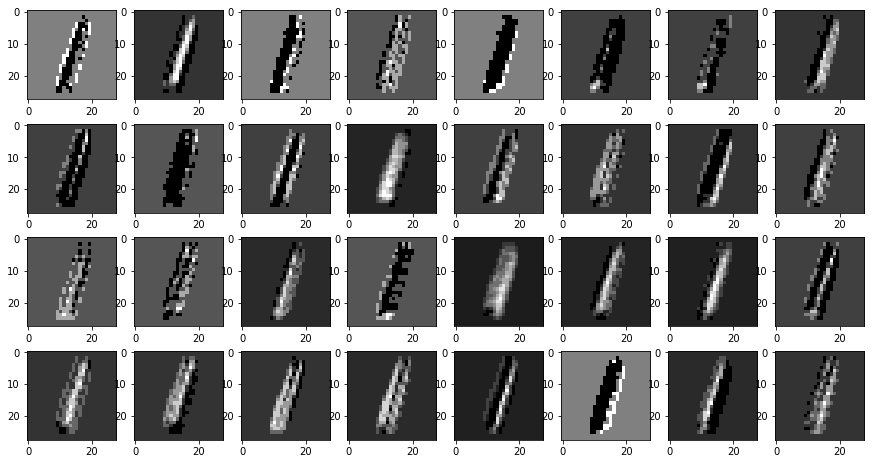

In [12]:
f, axarr = plt.subplots(4, 8, figsize=(15, 8))
for x in range(4):
    for y in range(8):
        axarr[x, y].imshow(Y[0][x * 8 + y].astype(float), cmap='gray')

In [13]:
%%time
Y1 = max_pool_2x2(Y)

CPU times: user 32 ms, sys: 44 ms, total: 76 ms
Wall time: 25.8 ms


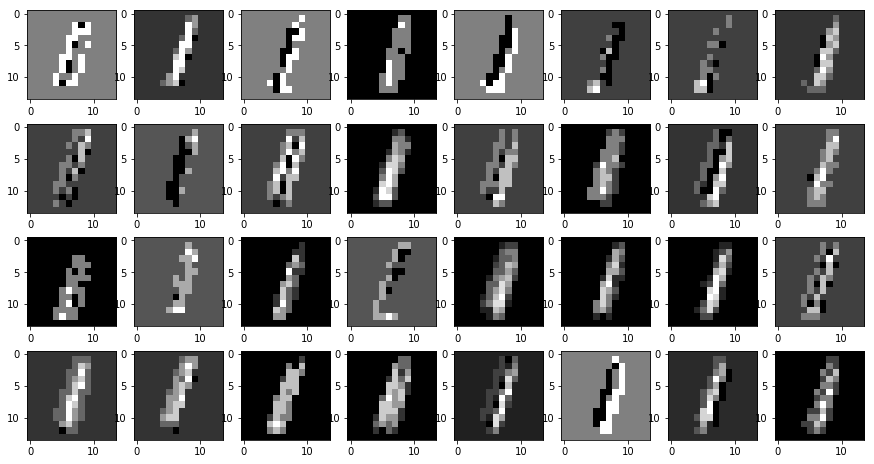

In [14]:
f, axarr = plt.subplots(4, 8, figsize=(15, 8))
for x in range(4):
    for y in range(8):
        axarr[x, y].imshow(Y1[0][x * 8 + y].astype(float), cmap='gray')

In [15]:
%%time
Y2 = conv2d(Y1, qint8_data_map['weights']['conv2'], qint8_data_map['bias']['conv2'])

CPU times: user 1min 42s, sys: 96 ms, total: 1min 42s
Wall time: 1min 42s


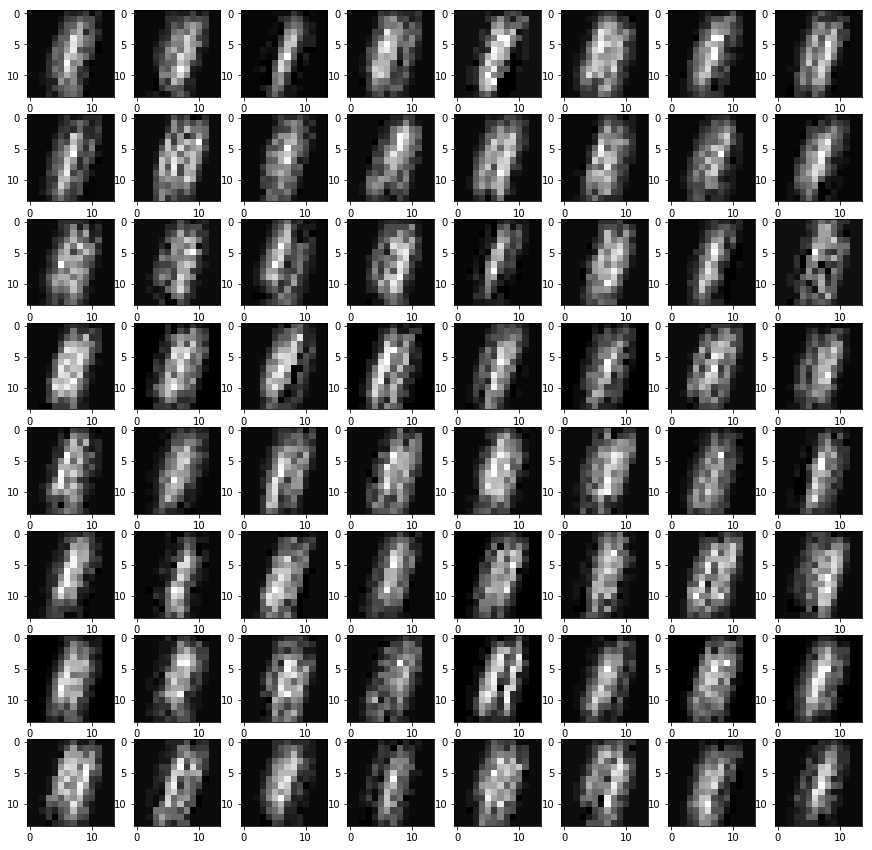

In [16]:
f, axarr = plt.subplots(8, 8, figsize=(15, 15))
for x in range(8):
    for y in range(8):
        axarr[x, y].imshow(Y2[0][x * 8 + y].astype(float), cmap='gray')

In [17]:
%%time
Y3 = max_pool_2x2(Y2)

CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 14.1 ms


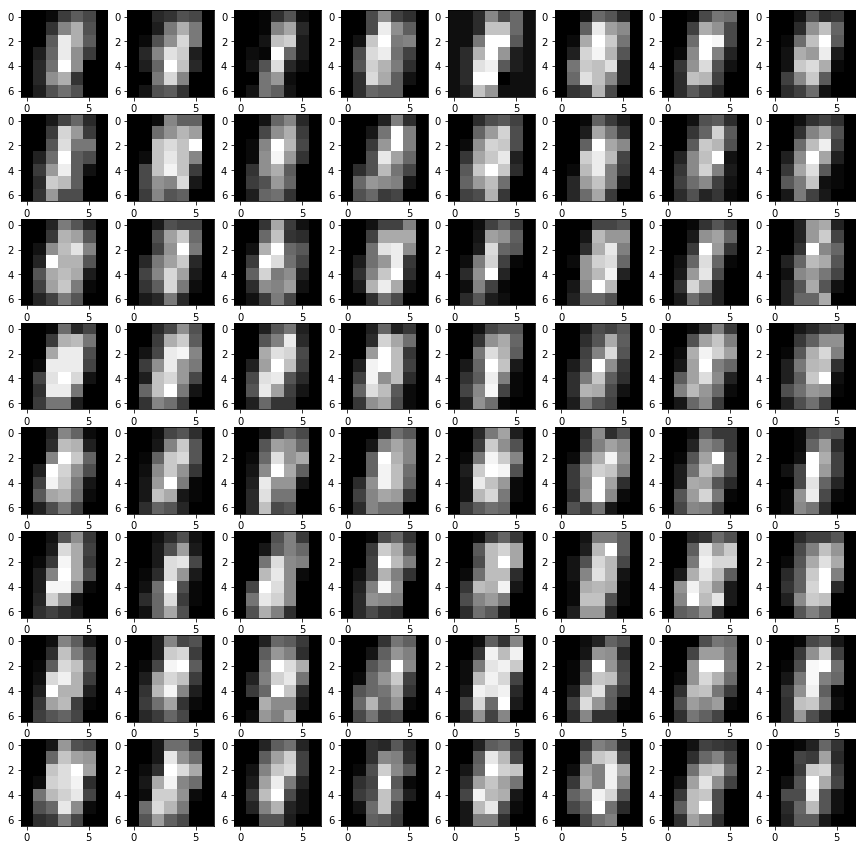

In [18]:
f, axarr = plt.subplots(8, 8, figsize=(15, 15))
for x in range(8):
    for y in range(8):
        axarr[x, y].imshow(Y3[0][x * 8 + y].astype(float), cmap='gray')

In [19]:
%%time
Y4 = fc(Y3.reshape((Y3.shape[0], -1)),
        qint8_data_map['weights']['fc1'],
        qint8_data_map['bias']['fc1'])

CPU times: user 38.9 s, sys: 72 ms, total: 38.9 s
Wall time: 38.9 s


In [20]:
%%time
Y5 = fc(Y4, qint8_data_map['weights']['fc2'], qint8_data_map['bias']['fc2'])

CPU times: user 128 ms, sys: 0 ns, total: 128 ms
Wall time: 125 ms


In [21]:
print(Y5.astype(float))
np.argmax(softmax(Y5[0]))

[[  0.    10.     0.     0.     7.     0.     0.     0.     8.5    6.75]]


1

### Challenges (No Solution)

1. Can you give several reasons why the current layer implementations are quite slow? (hint: consider the nature of Python)
2. Can you provide a performance optimised version?
3. Can you try to run the inference on the original TensorFlow model and compare the intermediate results with the quantised version?

### A Quantised CNN for MNIST

Maybe you can try to build a quantised MNIST CNN model from the examples given above!

In [26]:
def q_mnist(images, data_map, n):
    """
    TODO: implement quantised MNIST CNN model with a given batch of images, an original data_map
    and a target number of fractional bits n.
    The returned value should be the prediction result (a scalar)
    """
    print('creating quantised images and data ')
    q_img = np.array([convert_to_qint8(X, n).reshape(1, 28, 28)
                      for X in images])
    q_map = create_qint8_data_map(data_map, [n, n, n, n])
    print('conv1/pool1')
    Y0 = conv2d(q_img, q_map['weights']['conv1'], q_map['bias']['conv1'])
    Y1 = max_pool_2x2(Y0)
    print('conv2/pool2')
    Y2 = conv2d(Y1, q_map['weights']['conv2'], q_map['bias']['conv2'])
    Y3 = max_pool_2x2(Y2)
    print('fc1/fc2')
    Y4 = fc(Y3.reshape((Y3.shape[0], -1)), q_map['weights']['fc1'], q_map['bias']['fc1'])
    Y5 = fc(Y4, q_map['weights']['fc2'], q_map['bias']['fc2'])
    return [np.argmax(softmax(y)) for y in Y5]

In [27]:
# If you haven't optimised the performance yet, please just start with one test image 
q_mnist(mnist.test.images[:1], data_map, 4)

creating quantised images and data 
conv1/pool1
conv2/pool2
fc1/fc2


###  Challenges (No Solution)

1. Can you evaluate the accuracy of the quantised model?
2. Can you search for a quantised model that has the best accuracy?